In [82]:
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', None) # вывод таблицы целиком

%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [83]:
# Исходные данные для выполнения ДЗ

class SiStructure:
    def __init__(self, a, b, n, omega, Ex_x, Nb, V = 0) -> None:
        """Структура, содержащая характеристики боевой единицы

        Атрибуты
        ----------
        a : float
            Размер a
        b : float
            Размер b
        n : float
            Скорострельность, 1/мин
        omega : float
            Среднее число попаданий, необходимое для поражения целей
        Ex_x : float
            Характеристики рассеивания
        Nb : float
            Боекомплект: САУ100 = 40, САУ152 = 30, танк = 40, ПТУР = 2
        V : float
            Скорость передвижения, м/с

        Методы
        ------

        W(a,b,x) -> float
            Вероятность выхода из строя
        """
        self.a = a              # Размер a
        self.b = b              # Размер b
        self.n = n              # Скорострельность, 1/мин
        self.omega = omega      # Среднее число попаданий, необходимое для поражения целей
        self.Ex_x = Ex_x        # Характеристики рассеивания
        self.Nb = Nb
        self.V = V

    def F_x(self, x):
        return norm.cdf(x) - 0.5
    
    def sigma(self,x):
        return 1.48 * self.Ex_x * x

    def W(self,a,b,x):
        """Вероятность выхода из строя

        Параметры
        ----------
        a : float
            Размер a противника
        b : float
            Размер b противника
        x : float
            Расстояние до противника

        Returns
        -------
        float
            Вероятность выхода из строя
        """
        _sigma = self.sigma(x)
        P = 4 * self.F_x((b/2) / _sigma) * self.F_x((a/2) / _sigma)
        return P / self.omega

# # данные Максимки
# tank = SiStructure(a = 2.8, b = 2.0, n = 10, omega = 1.4, Ex_x = 1/1400, Nb = 40, V = 13)
# sau100 = SiStructure(a = 1.9, b = 2.1, n = 10, omega = 1.6, Ex_x = 1/1200, Nb = 40)
# sau152 = SiStructure(a = 1.9, b = 2.1, n = 10, omega = 1.3, Ex_x = 1/800, Nb = 30)
# ptur = SiStructure(a = 1.9, b = 2.1, n = 0, omega = 1.1, Ex_x = 1/1600, Nb = 2, V = 170)
# x0 = 1800 # Начальное расстояние

# # данные варианта Лазарева Аркадия
# tank = SiStructure(a = 2.7, b = 1.8, n = 13, omega = 1.6, Ex_x = 1/1000, Nb = 40, V = 13)
# sau100 = SiStructure(a = 2.6, b = 1.6, n = 11, omega = 2.0, Ex_x = 1/1300, Nb = 40)
# sau152 = SiStructure(a = 2.6, b = 1.6, n = 8, omega = 1.4, Ex_x = 1/700, Nb = 30)
# ptur = SiStructure(a = 2.6, b = 1.6, n = 0, omega = 1.0, Ex_x = 1/2500, Nb = 2, V = 240)
# x0 = 1300 # Начальное расстояние

# данные варианта Даниэля Михайлова
tank = SiStructure(a = 2.2, b = 1.7, n = 14, omega = 1.5, Ex_x = 1/900, Nb = 50, V = 9)
sau100 = SiStructure(a = 2.4, b = 2.2, n = 10, omega = 1.6, Ex_x = 1/1400, Nb = 50)
sau152 = SiStructure(a = 2.4, b = 2.2, n = 9, omega = 1.1, Ex_x = 1/800, Nb = 30)
ptur = SiStructure(a = 2.4, b = 2.2, n = 0, omega = 1.3, Ex_x = 1/1700, Nb = 2, V = 260)
x0 = 2800 # Начальное расстояние

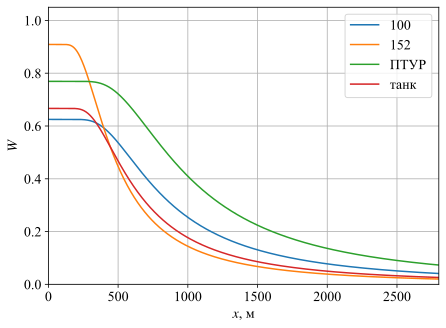

In [84]:
# Графики зависимости вероятности поражения от расстояния

xs = np.linspace(0.01, 5000, 1000)

Ws_tank = []
Ws_sau100 = []
Ws_sau152 = []
Ws_ptur = []

for x in xs:
    Ws_tank.append(tank.W(sau100.a, sau100.b, x))
    Ws_sau100.append(sau100.W(tank.a, tank.b, x))
    Ws_sau152.append(sau152.W(tank.a, tank.b, x))
    Ws_ptur.append(ptur.W(tank.a, tank.b, x))

plt.figure(figsize=(7,5))
plt.plot(xs, Ws_sau100, label='$100$')
plt.plot(xs, Ws_sau152, label='$152$')
plt.plot(xs, Ws_ptur, label='$ПТУР$')
plt.plot(xs, Ws_tank, label='$танк$')

plt.xlim(0,x0)
plt.ylim(0,1.05)

plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{W}$')

plt.legend()
plt.grid()
plt.show()

In [85]:
# Таблица W(P)
x_df=np.linspace(x0,1e-9, round(x0/100) + 1) # Массив значений расстояний

df = pd.DataFrame({
    'sigma_100': [sau100.sigma(x) for x in x_df],
    'sigma_152': [sau152.sigma(x) for x in x_df],
    'sigma_tank': [tank.sigma(x) for x in x_df],
    'Fa_100': [sau100.F_x(tank.a / 2 / sau100.sigma(x)) for x in x_df],
    'Fb_100': [sau100.F_x(tank.b / 2 / sau100.sigma(x)) for x in x_df],
    'Fa_152': [sau152.F_x(tank.a / 2 / sau152.sigma(x)) for x in x_df],
    'Fb_152': [sau152.F_x(tank.b / 2 / sau152.sigma(x)) for x in x_df],
    'Fa_tank': [tank.F_x(sau100.a / 2 / tank.sigma(x)) for x in x_df],
    'Fb_tank': [tank.F_x(sau100.b / 2 / tank.sigma(x)) for x in x_df],
    'W_100': [sau100.W(tank.a, tank.b, x) for x in x_df],
    'W_152': [sau152.W(tank.a, tank.b, x) for x in x_df],
    'W_tank': [tank.W(sau100.a, sau100.b, x) for x in x_df]
}, index = x_df)
df.columns.name = 'x'
df.index = df.index.astype('int')
for key, mod in zip(df.keys(),['{:,.3f}']*12):
    df[key] = df[key].map(mod.format)

display(df)

x,sigma_100,sigma_152,sigma_tank,Fa_100,Fb_100,Fa_152,Fb_152,Fa_tank,Fb_tank,W_100,W_152,W_tank
2800,2.960,5.180,4.604,0.145,0.113,0.084,0.065,0.103,0.094,0.041,0.020,0.026
2700,2.854,4.995,4.440,0.150,0.117,0.087,0.068,0.107,0.098,0.044,0.021,0.028
2600,2.749,4.810,4.276,0.155,0.121,0.090,0.070,0.111,0.102,0.047,0.023,0.030
2500,2.643,4.625,4.111,0.161,0.126,0.094,0.073,0.115,0.105,0.051,0.025,0.032
2400,2.537,4.440,3.947,0.168,0.131,0.098,0.076,0.119,0.110,0.055,0.027,0.035
2300,2.431,4.255,3.782,0.175,0.137,0.102,0.079,0.124,0.114,0.060,0.029,0.038
2200,2.326,4.070,3.618,0.182,0.143,0.107,0.083,0.130,0.119,0.065,0.032,0.041
2100,2.220,3.885,3.453,0.190,0.149,0.111,0.087,0.136,0.125,0.071,0.035,0.045
2000,2.114,3.700,3.289,0.199,0.156,0.117,0.091,0.142,0.131,0.078,0.039,0.050
1900,2.009,3.515,3.124,0.208,0.164,0.123,0.096,0.150,0.138,0.085,0.043,0.055


In [86]:
# # Дуэль Т и САУ с 100-мм ПТП
def duel(tank : SiStructure, sau : SiStructure):
    """Дуэль танка с САУ

    Parameters
    ----------
    tank : SiStructure
        объект танк
    sau : SiStructure
        объект САУ

    Returns
    -------
    dict
        словарь следующего вида:
        {
            't': numpy.array
                Отсортированный массив времен
            'who': numpy.array
                Массив кто выстрелил в это время
            'W_tild': numpy.array
                Массив вероятностей победы САУ
            'V_tild': numpy.array
                Массив вероятностей победы танка
            'x': numpy.array
                Массив расстояний между танком и САУ
            'crit_W': list
                Массив относительных отклонений вероятности от предыдущей для САУ
            'crit_V': list
                Массив относительных отклонений вероятности от предыдущей для танка
            'N_tank': int
                Израсходованный запас танка
            'N_sau': int
                Израсходованный запас САУ
            'M': float
                Матожидание САУ. Немного не сходится но и хер с ним, его никто нормально посчитать не может
        }
    """
    # массив времен
    ts = [0]

    # относительная скорость
    V_otn = sau.V + tank.V

    # расстояние
    x = x0
    xs = [x0]

    # массив кто выстрелил
    who_shot = ['сау']

    # моменты времени выстрелов САУ и танка
    t_sau = 0; t_tank = 4 - 1 / tank.n * 60

    # W и V
    Ws = [sau.W(tank.a, tank.b, x)]; Vs = [0]
    
    # W и V с тильдами
    W_tilds = [Ws[0]]; V_tilds = [0]

    # Израсходованный боезапас
    N_sau = 1; N_tank = 0

    # произведение 1 - W (или 1 - V)
    WV_minus_1 = 1 - Ws[-1]

    crit = True
    crit_W, crit_V = [1], [1]

    # матожидание сау
    M = 1

    while W_tilds[-1] + V_tilds[-1] < 1 and x > 0 and N_tank < tank.Nb and N_sau < sau.Nb and crit:
        # W_tilds[-1] + V_tilds[-1] < 1 - пока их сумма не равна 1
        # x > 0 - пока не встретились
        # N_tank < tank.Nb and N_sau < sau.Nb - пока боекомплект не израсходован
        # crit - пока отклонение прошлого W от нынешенего еще велико

        # время выстрелов
        t_sau += 1 / sau.n * 60
        t_tank += 1 / tank.n * 60
        
        # выстреливает сау
        if t_tank > t_sau:
            ts.append(t_sau) 
            who_shot.append('сау')
            x = x0 - V_otn * ts[-1]
            t_tank -= 1 / tank.n * 60     # возвращаем время танку
            Ws.append(sau.W(tank.a,tank.b,x))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1])
            M += WV_minus_1
            WV_minus_1 *= 1 - Ws[-1]
            N_sau += 1
        
        # выстреливает танк
        elif t_tank < t_sau:
            ts.append(t_tank)
            who_shot.append('танк')
            x = x0 - V_otn * ts[-1]
            t_sau -= 1 / sau.n * 60   # возвращаем время САУ
            Vs.append(tank.W(sau.a, sau.b, x))
            V_tilds.append(V_tilds[-1] + WV_minus_1 * Vs[-1])
            WV_minus_1 *= 1 - Vs[-1]
            N_tank += 1

            if V_tilds[0] == 0:
                V_tilds = V_tilds[1:]

        # выстрелили оба
        else:
            ts.append(t_tank)
            who_shot.append('оба')
            x = x0 - V_otn * ts[-1]
            Ws.append(sau.W(tank.a,tank.b,x))
            Vs.append(tank.W(sau.a, sau.b, x))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1] * (1 + (1 - Vs[-1]) / 2))
            V_tilds.append(V_tilds[-1] + WV_minus_1 * Vs[-1] * (1 + (1 - Ws[-1]) / 2))
            WV_minus_1 *= (1 - Ws[-1]) * (1 - Vs[-1])
            N_sau += 1
            N_tank += 1

        xs.append(x0 - V_otn * ts[-1])

        crit_W.append(abs(W_tilds[-2] - W_tilds[-1]) / W_tilds[-2] if len(W_tilds) > 1 else 1)
        crit_V.append(abs(V_tilds[-2] - V_tilds[-1]) / V_tilds[-2] if len(V_tilds) > 1 else 1)

        crit = crit_W[-1] > 0.01 or crit_V[-1] > 0.01

    return {
        't': np.array(ts),
        'who': np.array(who_shot),
        'W_tild': np.array(W_tilds),
        'V_tild': np.array(V_tilds),
        'x': np.array(xs),
        'crit_W': crit_W,
        'crit_V': crit_V,
        'N_tank': N_tank,
        'N_sau': N_sau,
        'M': M
    }

In [87]:
def cyclogram(res_duel, mm = '', save_name = None):
    """Построение циклограммы боя

    Parameters
    ----------
    res_duel : dict
        результаты дуэли
    mm : str, optional
        дополнительная запись к САУ на графике, by default ''
    save_name : str, optional
        путь для сохранения графика, by default None
    """
    
    plt.figure(figsize=(10,2))
    plt.scatter(res_duel['t'][res_duel['who'] == 'танк'],[1]*len(res_duel['V_tild']),marker = '^', zorder = 2)
    plt.scatter(res_duel['t'][res_duel['who'] == 'сау'],[2]*len(res_duel['W_tild']),marker = 'p', color = 'tab:red', zorder = 2)
    plt.yticks([1,2],['Танк 100-мм','САУ' + mm])
    plt.ylim(0.5,2.5)
    plt.grid(zorder = 1)
    plt.xlabel('$\mathit{t}$, с')
    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()

def dynamic_plot(res_duel, mm = '', kind = None, save_name = None):
    """Построение графика Динамика боя

    Parameters
    ----------
    res_duel : dict
        резльтаты дуэли
    mm : str, optional
        подпись к САУ на графике, by default ''
    kind : str, optional
        Если ваш ПТУР летит со скоростью света, а танком управляет черепашка Тортилья, то не надейтесь на нормальное
        решение. Однако если вы поставите этот параметр `'linear'`, то, может, спасете свои попочки от полета на орбиту, by default None
    save_name : str, optional
        название графика для его сохранения, by default None
    """

    # интерполяция
    t_sau = res_duel['t'][res_duel['who'] == 'сау']
    Wt_sau = res_duel['W_tild']
    if res_duel['who'][0] == 'танк':
        t_sau = np.insert(t_sau,0, res_duel['t'][0])
        Wt_sau = np.insert(Wt_sau,0,0)

    if len(Wt_sau) > 3:
        W_sau = interp1d(t_sau,Wt_sau,'cubic',fill_value='extrapolate')
    elif len(Wt_sau) > 2:
        W_sau = interp1d(t_sau,Wt_sau,'quadratic',fill_value='extrapolate')
    else:
        W_sau = interp1d(t_sau,Wt_sau,'linear',fill_value='extrapolate')

    t_tank = res_duel['t'][res_duel['who'] == 'танк']
    Wt_tank = res_duel['V_tild']
    if res_duel['who'][0] == 'сау':
        t_tank = np.insert(t_tank,0,res_duel['t'][0])
        Wt_tank = np.insert(Wt_tank,0,0)

    if len(Wt_tank) > 3:
        W_tank = interp1d(t_tank,Wt_tank,'cubic',fill_value='extrapolate')
    elif len(Wt_tank) > 2:
        W_tank = interp1d(t_tank,Wt_tank,'quadratic',fill_value='extrapolate')
    else:
        W_tank = interp1d(t_tank,Wt_tank,'linear',fill_value='extrapolate')
    
    if kind == 'linear':
        W_tank = interp1d(t_tank,Wt_tank,'linear',fill_value='extrapolate')
        W_sau = interp1d(t_sau,Wt_sau,'linear',fill_value='extrapolate')

    W_nobody = lambda t: 1 - W_sau(t) - W_tank(t)

    ts = np.linspace(res_duel['t'][0],res_duel['t'][-1],300)

    plt.figure(figsize=(7,5))
    plt.plot(ts,W_tank(ts),label = 'Танк 100-мм',zorder = 2)
    plt.scatter(res_duel['t'][res_duel['who'] == 'танк'],res_duel['V_tild'],edgecolors='tab:blue',facecolor = 'white',zorder = 3)
    plt.plot(ts,W_sau(ts),label = 'САУ' + mm, color = 'tab:red',zorder = 2)
    plt.scatter(res_duel['t'][res_duel['who'] == 'сау'],res_duel['W_tild'],edgecolors='tab:red',facecolor = 'white',zorder = 3)
    plt.plot(ts,W_nobody(ts), label = 'Ничья',color = 'tab:green',zorder = 2)
    plt.scatter(res_duel['t'],W_nobody(res_duel['t']),edgecolors='tab:green',facecolor = 'white',zorder = 3)
    plt.ylim(0,1)
    plt.grid(zorder = 1)
    plt.legend()
    plt.xlabel('$\mathit{t}$, с')
    plt.ylabel('$\mathit{\\tilde{W}}$')
    plt.xlim(0,ts[-1])
    plt.show()

def duel_dataframe(res_duel, kind = None):
    """Табличка с боем

    Parameters
    ----------
    res_duel : dict
        Результаты дуэли
    kind : str, optional
        Если ваш ПТУР летит со скоростью света, а танком управляет черепашка Тортилья, то не надейтесь на нормальное
        решение. Однако если вы поставите этот параметр `'linear'`, то, может, спасете свои попочки от полета на орбиту. 
        Если вы изменили в dynamic_plot этот параметр, то его необходимо задать и здесь, by default None
    """
    WVs = []
    whos = []
    Ns_tank = 0
    Ns_sau = 0
    Ns = []

    for t, who in zip(res_duel['t'],res_duel['who']):
        if who == 'сау' or who == 'оба':
            whos.append("W")
            Ns_sau += 1
            Ns.append(Ns_sau)
            WVs.append(res_duel['W_tild'][Ns_sau - 1])
        if who == 'танк' or who == 'оба':
            whos.append("V")
            Ns_tank += 1
            Ns.append(Ns_tank)
            WVs.append(res_duel['V_tild'][Ns_tank - 1])

    # расчет вероятности ничьи снова
    t_sau = res_duel['t'][res_duel['who'] == 'сау']
    Wt_sau = res_duel['W_tild']
    if res_duel['who'][0] == 'танк':
        t_sau = np.insert(t_sau,0, res_duel['t'][0])
        Wt_sau = np.insert(Wt_sau,0,0)

    if len(Wt_sau) > 3:
        W_sau = interp1d(t_sau,Wt_sau,'cubic',fill_value='extrapolate')
    elif len(Wt_sau) > 2:
        W_sau = interp1d(t_sau,Wt_sau,'quadratic',fill_value='extrapolate')
    else:
        W_sau = interp1d(t_sau,Wt_sau,'linear',fill_value='extrapolate')

    t_tank = res_duel['t'][res_duel['who'] == 'танк']
    Wt_tank = res_duel['V_tild']
    if res_duel['who'][0] == 'сау':
        t_tank = np.insert(t_tank,0,res_duel['t'][0])
        Wt_tank = np.insert(Wt_tank,0,0)

    if len(Wt_tank) > 3:
        W_tank = interp1d(t_tank,Wt_tank,'cubic',fill_value='extrapolate')
    elif len(Wt_tank) > 2:
        W_tank = interp1d(t_tank,Wt_tank,'quadratic',fill_value='extrapolate')
    else:
        W_tank = interp1d(t_tank,Wt_tank,'linear',fill_value='extrapolate')

    if kind == 'linear':
        W_tank = interp1d(t_tank,Wt_tank,'linear',fill_value='extrapolate')
        W_sau = interp1d(t_sau,Wt_sau,'linear',fill_value='extrapolate')

    W_nobody = lambda t: 1 - W_sau(t) - W_tank(t)
    Ws_nobody = W_nobody(res_duel['t'])

    df = pd.DataFrame({
        'n': Ns,
        't': res_duel['t'],
        'Вер. победы': WVs,
        'Ничья': Ws_nobody,
        'x': res_duel['x'],
        'crit_W': res_duel['crit_W'],
        'crit_V': res_duel['crit_V']
    }, index = whos)
    df.columns.name = 'W/V'
    for key, mod in zip(df.keys(),['{:,.0f}','{:,.3f}','{:,.3f}','{:,.3f}','{:,.2f}','{:,.3f}','{:,.3f}']):
        df[key] = df[key].map(mod.format)

    display(df)

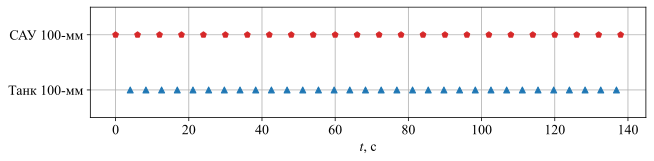

W/V,n,t,Вер. победы,Ничья,x,crit_W,crit_V
W,1,0.000,0.041,0.959,"2,800.00",1.000,1.000
V,1,4.000,0.025,0.907,"2,764.00",1.000,1.000
W,2,6.000,0.081,0.882,"2,746.00",0.969,1.000
V,2,8.286,0.050,0.855,"2,725.43",0.969,0.958
W,3,12.000,0.119,0.811,"2,692.00",0.476,0.958
V,3,12.571,0.073,0.804,"2,686.86",0.476,0.468
V,4,16.857,0.096,0.755,"2,648.29",0.476,0.319
W,4,18.000,0.155,0.742,"2,638.00",0.303,0.319
V,5,21.143,0.119,0.708,"2,609.71",0.303,0.230
W,5,24.000,0.190,0.677,"2,584.00",0.224,0.230


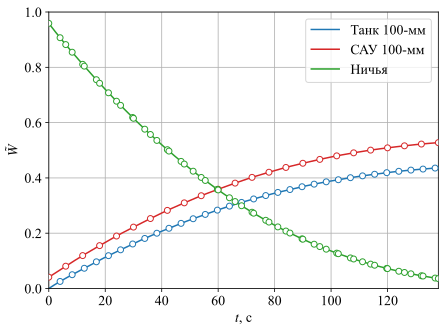

In [88]:
res100 = duel(tank,sau100)
cyclogram(res100,' 100-мм')
duel_dataframe(res100)
dynamic_plot(res100,' 100-мм')

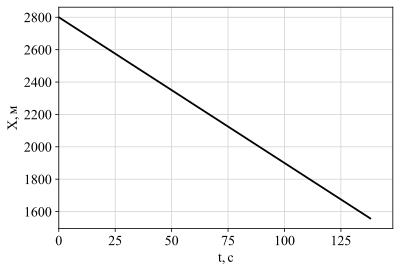

In [89]:
# График зависимости расстояния от времени
def plot_X_t(tmax):
    """Построение графика зависимости расстояния от времени

    Parameters
    ----------
    tmax : float
        максимальное значение в массиве времени
    """
    tt = np.linspace(0, tmax) # массив значений времени

    xx = lambda t: x0 - tank.V * t

    plt.figure(figsize=(6,4))
    plt.plot(tt, xx(tt), color = 'black', lw = 1.8)
    plt.grid(color = 'lightgray')
    plt.xlabel('$t, c$')
    plt.ylabel('$X, м$')

    plt.xlim(0, tmax+10)

plot_X_t(138)

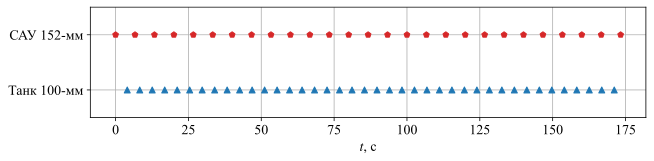

W/V,n,t,Вер. победы,Ничья,x,crit_W,crit_V
W,1,0.000,0.020,0.980,"2,800.00",1.000,1.000
V,1,4.000,0.026,0.942,"2,764.00",1.000,1.000
W,2,6.667,0.040,0.918,"2,740.00",0.996,1.000
V,2,8.286,0.052,0.904,"2,725.43",0.996,0.980
V,3,12.571,0.077,0.866,"2,686.86",0.996,0.495
W,3,13.333,0.059,0.860,"2,680.00",0.483,0.495
V,4,16.857,0.102,0.829,"2,648.29",0.483,0.324
W,4,20.000,0.078,0.802,"2,620.00",0.323,0.324
V,5,21.143,0.126,0.792,"2,609.71",0.323,0.239
V,6,25.429,0.151,0.756,"2,571.14",0.323,0.193


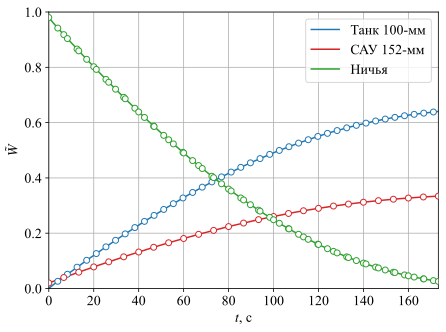

In [90]:
res152 = duel(tank,sau152)
cyclogram(res152,' 152-мм')
duel_dataframe(res152)
dynamic_plot(res152,' 152-мм')

In [91]:
def duel_ptur(tank : SiStructure, ptur : SiStructure):
    
    # массив времен
    ts = []

    # относительная скорость
    V_otn = tank.V

    # расстояние
    x = x0
    x_ptur = x

    t_ptur = 0; t_tank = 4 - 1 / tank.n * 60
    Ws = [0]; Vs = [0]
    W_tilds = [0]; V_tilds = [0]
    N_ptur = 0; N_tank = 0
    who_shot = []

    # произведение 1 - W (или 1 - V)
    WV_minus_1 = 1

    # матожидание птур
    M = 0

    while W_tilds[-1] + V_tilds[-1] < 1 and x > 0 and N_tank < tank.Nb and N_ptur < ptur.Nb:
        # W_tilds[-1] + V_tilds[-1] < 1 - пока их сумма не равна 1
        # x > 0 - пока не встретились
        # N_tank < tank.Nb and N_sau < sau.Nb - пока боекомплект не израсходован

        # время выстрелов
        t_ptur += x_ptur / (ptur.V + V_otn)
        t_tank += 1 / tank.n * 60
    
        # попадает птур
        if t_tank > t_ptur:
            ts.append(t_ptur)
            who_shot.append('сау')
            x = x0 - V_otn * ts[-1]
            x_ptur = x
            t_tank -= 1 / tank.n * 60     # возвращаем время танку
            Ws.append(ptur.W(tank.a,tank.b,x))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1])
            M += WV_minus_1
            WV_minus_1 *= 1 - Ws[-1]
            N_ptur += 1
        
        # выстреливает танк
        elif t_tank < t_ptur:
            ts.append(t_tank)
            who_shot.append('танк')
            t_ptur -= x_ptur / (ptur.V + V_otn)   # возвращаем время САУ
            x = x0 - V_otn * ts[-1]
            Vs.append(tank.W(ptur.a, ptur.b, x))
            V_tilds.append(V_tilds[-1] + WV_minus_1 * Vs[-1])
            WV_minus_1 *= 1 - Vs[-1]
            N_tank += 1

        # выстрелили оба
        else:
            ts.append(t_tank)
            who_shot.append('оба')
            x = x0 - V_otn * ts[-1]
            Ws.append(ptur.W(tank.a,tank.b,x))
            Vs.append(tank.W(ptur.a, ptur.b, x))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1] * (1 + (1 - Vs[-1]) / 2))
            V_tilds.append(V_tilds[-1] + WV_minus_1 * Vs[-1] * (1 + (1 - Ws[-1]) / 2))
            WV_minus_1 *= (1 - Ws[-1]) * (1 - Vs[-1])
            N_ptur += 1
            N_tank += 1

    return {
        't': np.array(ts),
        'who': np.array(who_shot),
        'W_tild': np.array(W_tilds[1:]),
        'V_tild': np.array(V_tilds[1:]),
        'N_tank': N_tank,
        'N_sau': N_ptur,
        'M': M
    }

def cyclogram_ptur(res_duel, mm = '', save_name = None):
    
    plt.figure(figsize=(7,2))
    plt.scatter(res_duel['t'][res_duel['who'] == 'танк'],[1]*len(res_duel['V_tild']),marker = '^', zorder = 2)
    t_ptur = np.repeat(res_duel['t'][res_duel['who'] == 'сау'],2)[:-1]
    t_ptur = np.insert(t_ptur,0,0)
    dots_ptur = [2,1] * int(len(t_ptur) / 2)
    plt.plot(t_ptur,dots_ptur,ls = '--',marker = 'p', color = 'tab:red', zorder = 2)
    plt.yticks([1,2],['Танк 100-мм','САУ' + mm])
    plt.ylim(0.5,2.5)
    plt.grid(zorder = 1)
    plt.xlabel('$\mathit{t}$, с')
    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()

def ptur_dataframe(res_duel, kind = None):
    WVs = []
    whos = []
    Ns_tank = 0
    Ns_sau = 0
    Ns = []

    for t, who in zip(res_duel['t'],res_duel['who']):
        if who == 'сау' or who == 'оба':
            whos.append("W")
            Ns_sau += 1
            Ns.append(Ns_sau)
            WVs.append(res_duel['W_tild'][Ns_sau - 1])
        if who == 'танк' or who == 'оба':
            whos.append("V")
            Ns_tank += 1
            Ns.append(Ns_tank)
            WVs.append(res_duel['V_tild'][Ns_tank - 1])

    # расчет вероятности ничьи снова
    t_sau = res_duel['t'][res_duel['who'] == 'сау']
    Wt_sau = res_duel['W_tild']
    if res_duel['who'][0] == 'танк':
        t_sau = np.insert(t_sau,0, res_duel['t'][0])
        Wt_sau = np.insert(Wt_sau,0,0)

    if len(Wt_sau) > 3:
        W_sau = interp1d(t_sau,Wt_sau,'cubic',fill_value='extrapolate')
    elif len(Wt_sau) > 2:
        W_sau = interp1d(t_sau,Wt_sau,'quadratic',fill_value='extrapolate')
    else:
        W_sau = interp1d(t_sau,Wt_sau,'linear',fill_value='extrapolate')

    t_tank = res_duel['t'][res_duel['who'] == 'танк']
    Wt_tank = res_duel['V_tild']
    if res_duel['who'][0] == 'сау':
        t_tank = np.insert(t_tank,0,res_duel['t'][0])
        Wt_tank = np.insert(Wt_tank,0,0)

    if len(Wt_tank) > 3:
        W_tank = interp1d(t_tank,Wt_tank,'cubic',fill_value='extrapolate')
    elif len(Wt_tank) > 2:
        W_tank = interp1d(t_tank,Wt_tank,'quadratic',fill_value='extrapolate')
    else:
        W_tank = interp1d(t_tank,Wt_tank,'linear',fill_value='extrapolate')

    if kind == 'linear':
        W_sau = interp1d(t_sau,Wt_sau,'linear',fill_value='extrapolate')
        W_tank = interp1d(t_tank,Wt_tank,'linear',fill_value='extrapolate')

    W_nobody = lambda t: 1 - W_sau(t) - W_tank(t)
    Ws_nobody = W_nobody(res_duel['t'])
        
    df = pd.DataFrame({
        'n': Ns,
        't': res_duel['t'],
        'Вер. победы': WVs,
        'Ничья': Ws_nobody,
    }, index = whos)
    df.columns.name = 'W/V'
    for key, mod in zip(df.keys(),['{:,.0f}','{:,.3f}','{:,.3f}','{:,.3f}']):
        df[key] = df[key].map(mod.format)

    display(df)

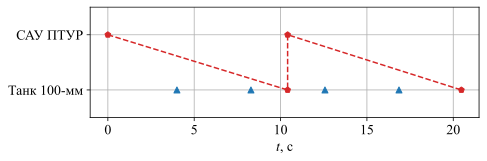

W/V,n,t,Вер. победы,Ничья
V,1,4.000,0.027,0.973
V,2,8.286,0.053,0.898
W,1,10.409,0.074,0.861
V,3,12.571,0.078,0.834
V,4,16.857,0.102,0.780
W,2,20.470,0.142,0.735


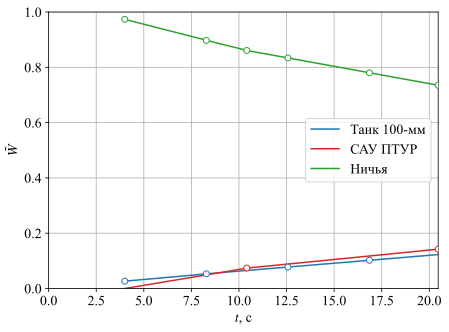

In [92]:
res_ptur = duel_ptur(tank,ptur)
cyclogram_ptur(res_ptur,' ПТУР')
ptur_dataframe(res_ptur,'linear')
dynamic_plot(res_ptur,' ПТУР','linear')

In [97]:
# итоги всего этого говна
print(f"1. Эффективность: W_100 = {res100['W_tild'][-1]:.3f}, W_152 = {res152['W_tild'][-1]:.3f}, W_ptur = {res_ptur['W_tild'][-1]:.3f};\n\
2. Время протекания дуэли: t_100 = {res100['t'][-1]:.3f}, t_152 = {res152['t'][-1]:.3f}, t_ptur = {res_ptur['t'][-1]:.3f};\n\
3. Расход боеприпасов: N_100 = {res100['N_sau']}, N_152 = {res152['N_sau']}, N_ptur = {res_ptur['N_sau']}.\n")

# Критерий
C_100 = 100
C_152 = 300
C_ptur = 600

print('Мат. ожидание ')
def E(res_duel,C,Nb):
    C_sau = 10000
    print(res_duel['M'])
    return (C * res_duel['M'] + (C_sau + (Nb - res_duel['M']) * C) * res_duel['V_tild'][-1]) / res_duel['W_tild'][-1]

E_100 = E(res100,C_100,sau100.Nb)
E_152 = E(res152,C_152,sau152.Nb)
E_ptur = E(res_ptur,C_ptur,ptur.Nb)

print(f"Критерий оптимальности: Э_100 = {E_100:.1f}, Э_152 = {E_152:.1f}, Э_ptur = {E_ptur:.1f};\n\
Самый лучший вариант с Э_min = {min(E_100,E_152,E_ptur):.1f}")

1. Эффективность: W_100 = 0.528, W_152 = 0.334, W_ptur = 0.142;
2. Время протекания дуэли: t_100 = 138.000, t_152 = 173.333, t_ptur = 20.470;
3. Расход боеприпасов: N_100 = 24, N_152 = 27, N_ptur = 2.

Мат. ожидание 
9.530463551712993
10.991480671454674
1.7710388447039842
Критерий оптимальности: Э_100 = 13403.3, Э_152 = 39893.0, Э_ptur = 14752.3;
Самый лучший вариант с Э_min = 13403.3
